In [124]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import libpysal
import numpy as np
import pysal
import pandas as pd
#from libpysal.weights.contiguity import Queen
from libpysal.weights import Queen, Rook, KNN, Kernel
from splot.libpysal import plot_spatial_weights

import pickle

from shapely.ops import cascaded_union

In [125]:
pathW = 'maps/Wojewodztwa/Województwa.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdfW = gpd.read_file(pathW) 
for i in range(len(gdfW.JPT_NAZWA_)):
    gdfW.JPT_NAZWA_[i] = gdfW.JPT_NAZWA_[i].encode("latin1","strict").decode('utf-8')
#print(gdf.head())

pathP = 'maps/Powiaty/Powiaty.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdfP = gpd.read_file(pathP) 
for i in range(len(gdfP.JPT_NAZWA_)):
    gdfP.JPT_NAZWA_[i] = gdfP.JPT_NAZWA_[i].encode("latin1","strict").decode('utf-8')
#print(gdf.head())

<ipython-input-125-9bf788b4e12a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdfW.JPT_NAZWA_[i] = gdfW.JPT_NAZWA_[i].encode("latin1","strict").decode('utf-8')
<ipython-input-125-9bf788b4e12a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdfP.JPT_NAZWA_[i] = gdfP.JPT_NAZWA_[i].encode("latin1","strict").decode('utf-8')


In [126]:
gdfP['JPT_NAZWA_'].shape

(380,)

In [127]:
path = 'maps/wojewodztwa/województwa.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdf = gpd.read_file(path) 
for i in range(len(gdf.jpt_nazwa_)):
    gdf.jpt_nazwa_[i] = gdf.jpt_nazwa_[i].encode("latin1","strict").decode('utf-8')
#print(gdf.head())

gdf = pd.merge(gdfW.loc[:,['JPT_NAZWA_']],gdf,left_on='JPT_NAZWA_',right_on='jpt_nazwa_')
del gdf['JPT_NAZWA_']
gdf['jpt_nazwa_']

<ipython-input-127-fa3efdbd9338>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.jpt_nazwa_[i] = gdf.jpt_nazwa_[i].encode("latin1","strict").decode('utf-8')


0                 śląskie
1                opolskie
2           wielkopolskie
3      zachodniopomorskie
4          świętokrzyskie
5      kujawsko-pomorskie
6               podlaskie
7            dolnośląskie
8            podkarpackie
9             małopolskie
10              pomorskie
11    warmińsko-mazurskie
12                łódzkie
13            mazowieckie
14              lubelskie
15               lubuskie
Name: jpt_nazwa_, dtype: object

In [128]:
#weights = Queen.from_dataframe(gdf)
wq = Queen.from_dataframe(gdf)
wq_W = Queen.from_dataframe(gdfW)
wq_P = Queen.from_dataframe(gdfP)

(137166.64563126868, 896406.6565342785, 101133.9541251598, 807108.9159854098)

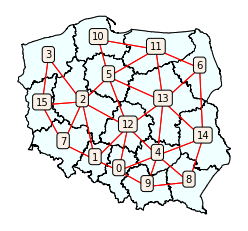

In [129]:
pos_w = {}

woj = gdf
woj['centroid'] = woj['geometry'].centroid

ax = gdf.plot(edgecolor='grey', facecolor='w')
fig, ax = wq.plot(gdf, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))
#plt.subplots(1, figsize=(50,50))
gdf.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in woj.iterrows():
    ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)
    pos_w[point[0]] = [point[1]['centroid'].x, point[1]['centroid'].y]

ax.axis('off')

In [130]:
gdf['jpt_nazwa_']

0                 śląskie
1                opolskie
2           wielkopolskie
3      zachodniopomorskie
4          świętokrzyskie
5      kujawsko-pomorskie
6               podlaskie
7            dolnośląskie
8            podkarpackie
9             małopolskie
10              pomorskie
11    warmińsko-mazurskie
12                łódzkie
13            mazowieckie
14              lubelskie
15               lubuskie
Name: jpt_nazwa_, dtype: object

In [172]:
# making one polygon
from shapely.ops import unary_union, cascaded_union
from shapely.geometry import Polygon
coords =[]
for i,polygon in enumerate(gdf.geometry[0]):
    if(i>2):
        coords.extend(polygon.exterior.coords[:-1])   
#boundary = gpd.GeoSeries(cascaded_union(gdf.geometry[0]))
slunsk = Polygon(coords)

In [173]:
gdf.geometry[0] = slunsk

In [174]:
gdf['geometry_small'] = gdf.geometry
from shapely import geometry
for i in range(gdf.shape[0]):
    coords = np.array(gdf.geometry[i].exterior)
        
    factor = 0.1
    
    # code from nathan
    xs = [i[0] for i in coords]
    ys = [i[1] for i in coords]
    x_center = 0.5 * min(xs) + 0.5 * max(xs)
    y_center = 0.5 * min(ys) + 0.5 * max(ys)

    min_corner = geometry.Point(min(xs), min(ys))
    max_corner = geometry.Point(max(xs), max(ys))
    center = geometry.Point(x_center, y_center)
    shrink_distance = center.distance(min_corner)*factor

    #assert abs(gdf['geometry'][i] - center.distance(max_corner)) < 0.0001
    my_polygon = geometry.Polygon(coords)
    gdf['geometry_small'][i] = my_polygon.buffer(-shrink_distance)

In [197]:
gdf['wojewodztwo'] = gdf['jpt_nazwa_'].str.upper()

In [198]:
gdf[['wojewodztwo','color']] 

,wojewodztwo,color
0,ŚLĄSKIE,"(1.0, 0.0, 0.16, 1.0)"
1,OPOLSKIE,"(1.0, 0.1981981981981982, 0.0, 1.0)"
2,WIELKOPOLSKIE,"(1.0, 0.5585585585585585, 0.0, 1.0)"
3,ZACHODNIOPOMORSKIE,"(1.0, 0.9189189189189187, 0.0, 1.0)"
4,ŚWIĘTOKRZYSKIE,"(0.7207207207207207, 1.0, 0.0, 1.0)"
5,KUJAWSKO-POMORSKIE,"(0.36036036036036034, 1.0, 0.0, 1.0)"
6,PODLASKIE,"(0.0, 1.0, 0.0, 1.0)"
7,DOLNOŚLĄSKIE,"(0.0, 1.0, 0.35842293906810047, 1.0)"
8,PODKARPACKIE,"(0.0, 1.0, 0.7168458781362009, 1.0)"
9,MAŁOPOLSKIE,"(0.0, 0.9239130434782606, 1.0, 1.0)"


<ipython-input-194-1fb6210495e3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['color'][i] = cm(i)


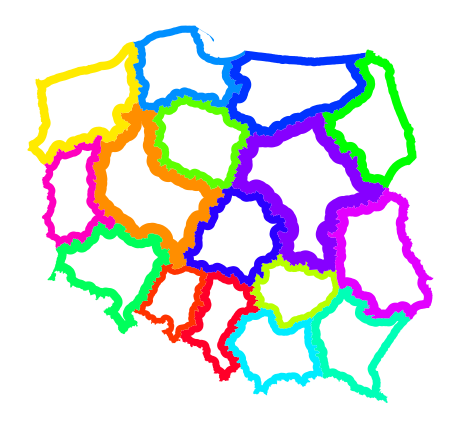

In [194]:
woj = gdf
woj['centroid'] = woj['geometry'].centroid

gdf['color'] = [
    'tab:blue','tab:brown','tab:red','tab:orange',
    'tab:green','tab:purple','tab:pink','tab:gray',
    'tab:olive','tab:cyan','magenta','purple',
    'c','royalblue','indigo','olive']

cm = plt.get_cmap('gist_rainbow',16)
NUM_COLORS = 16
for i in range(NUM_COLORS):
    gdf['color'][i] = cm(i)

ax = gdf.plot(edgecolor='white', facecolor='w', figsize=(8, 8))
#plt.subplots(1, figsize=(50,50))
gdf.plot(color=gdf['color'], 
         edgecolor=gdf['color'], ax=ax, linewidth=0)
gdf.geometry_small.plot(color='white', 
         edgecolor=gdf['color'], ax=ax, linewidth=0)
props = dict(boxstyle='round', facecolor='linen', alpha=1)

ax.axis('off')
plt.show()

In [186]:
cm

In [33]:
pos_p = {}

pwtP = gdfP
pwtP['centroid'] = pwtP['geometry'].centroid
'''
ax = gdfP.plot(edgecolor='grey', facecolor='w')
fig, ax = wq_P.plot(gdfP, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))
        '''
#plt.subplots(1, figsize=(50,50))
#gdfP.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in pwt.iterrows():
    '''ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)'''
    pos_p[point[0]] = [point[1]['centroid'].x, point[1]['centroid'].y]

#ax.axis('off')

<ipython-input-33-945d3938cb42>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pwtP['centroid'] = pwtP['geometry'].centroid


<ipython-input-9-e518302bb62d>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  woj['centroid'] = woj['geometry'].centroid
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/

(13.621739949250054, 24.646927985750054, 48.71032801055003, 55.12813517445003)

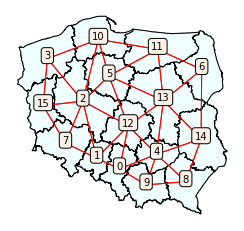

In [9]:
woj = gdfW
woj['centroid'] = woj['geometry'].centroid

ax = gdfW.plot(edgecolor='grey', facecolor='w')
fig, ax = wq_W.plot(gdfW, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))
#plt.subplots(1, figsize=(50,50))
gdfW.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in woj.iterrows():
    ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)

ax.axis('off')

<ipython-input-20-341d4c63a137>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pwt['centroid'] = pwt['geometry'].centroid
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x

/home/marek/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:1306: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.apply(lambda p: p.y),


(13.621739949250054, 24.646927985750054, 48.71032801055003, 55.12813517445003)

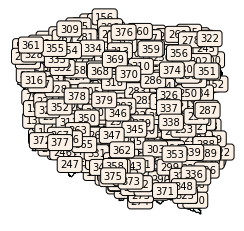

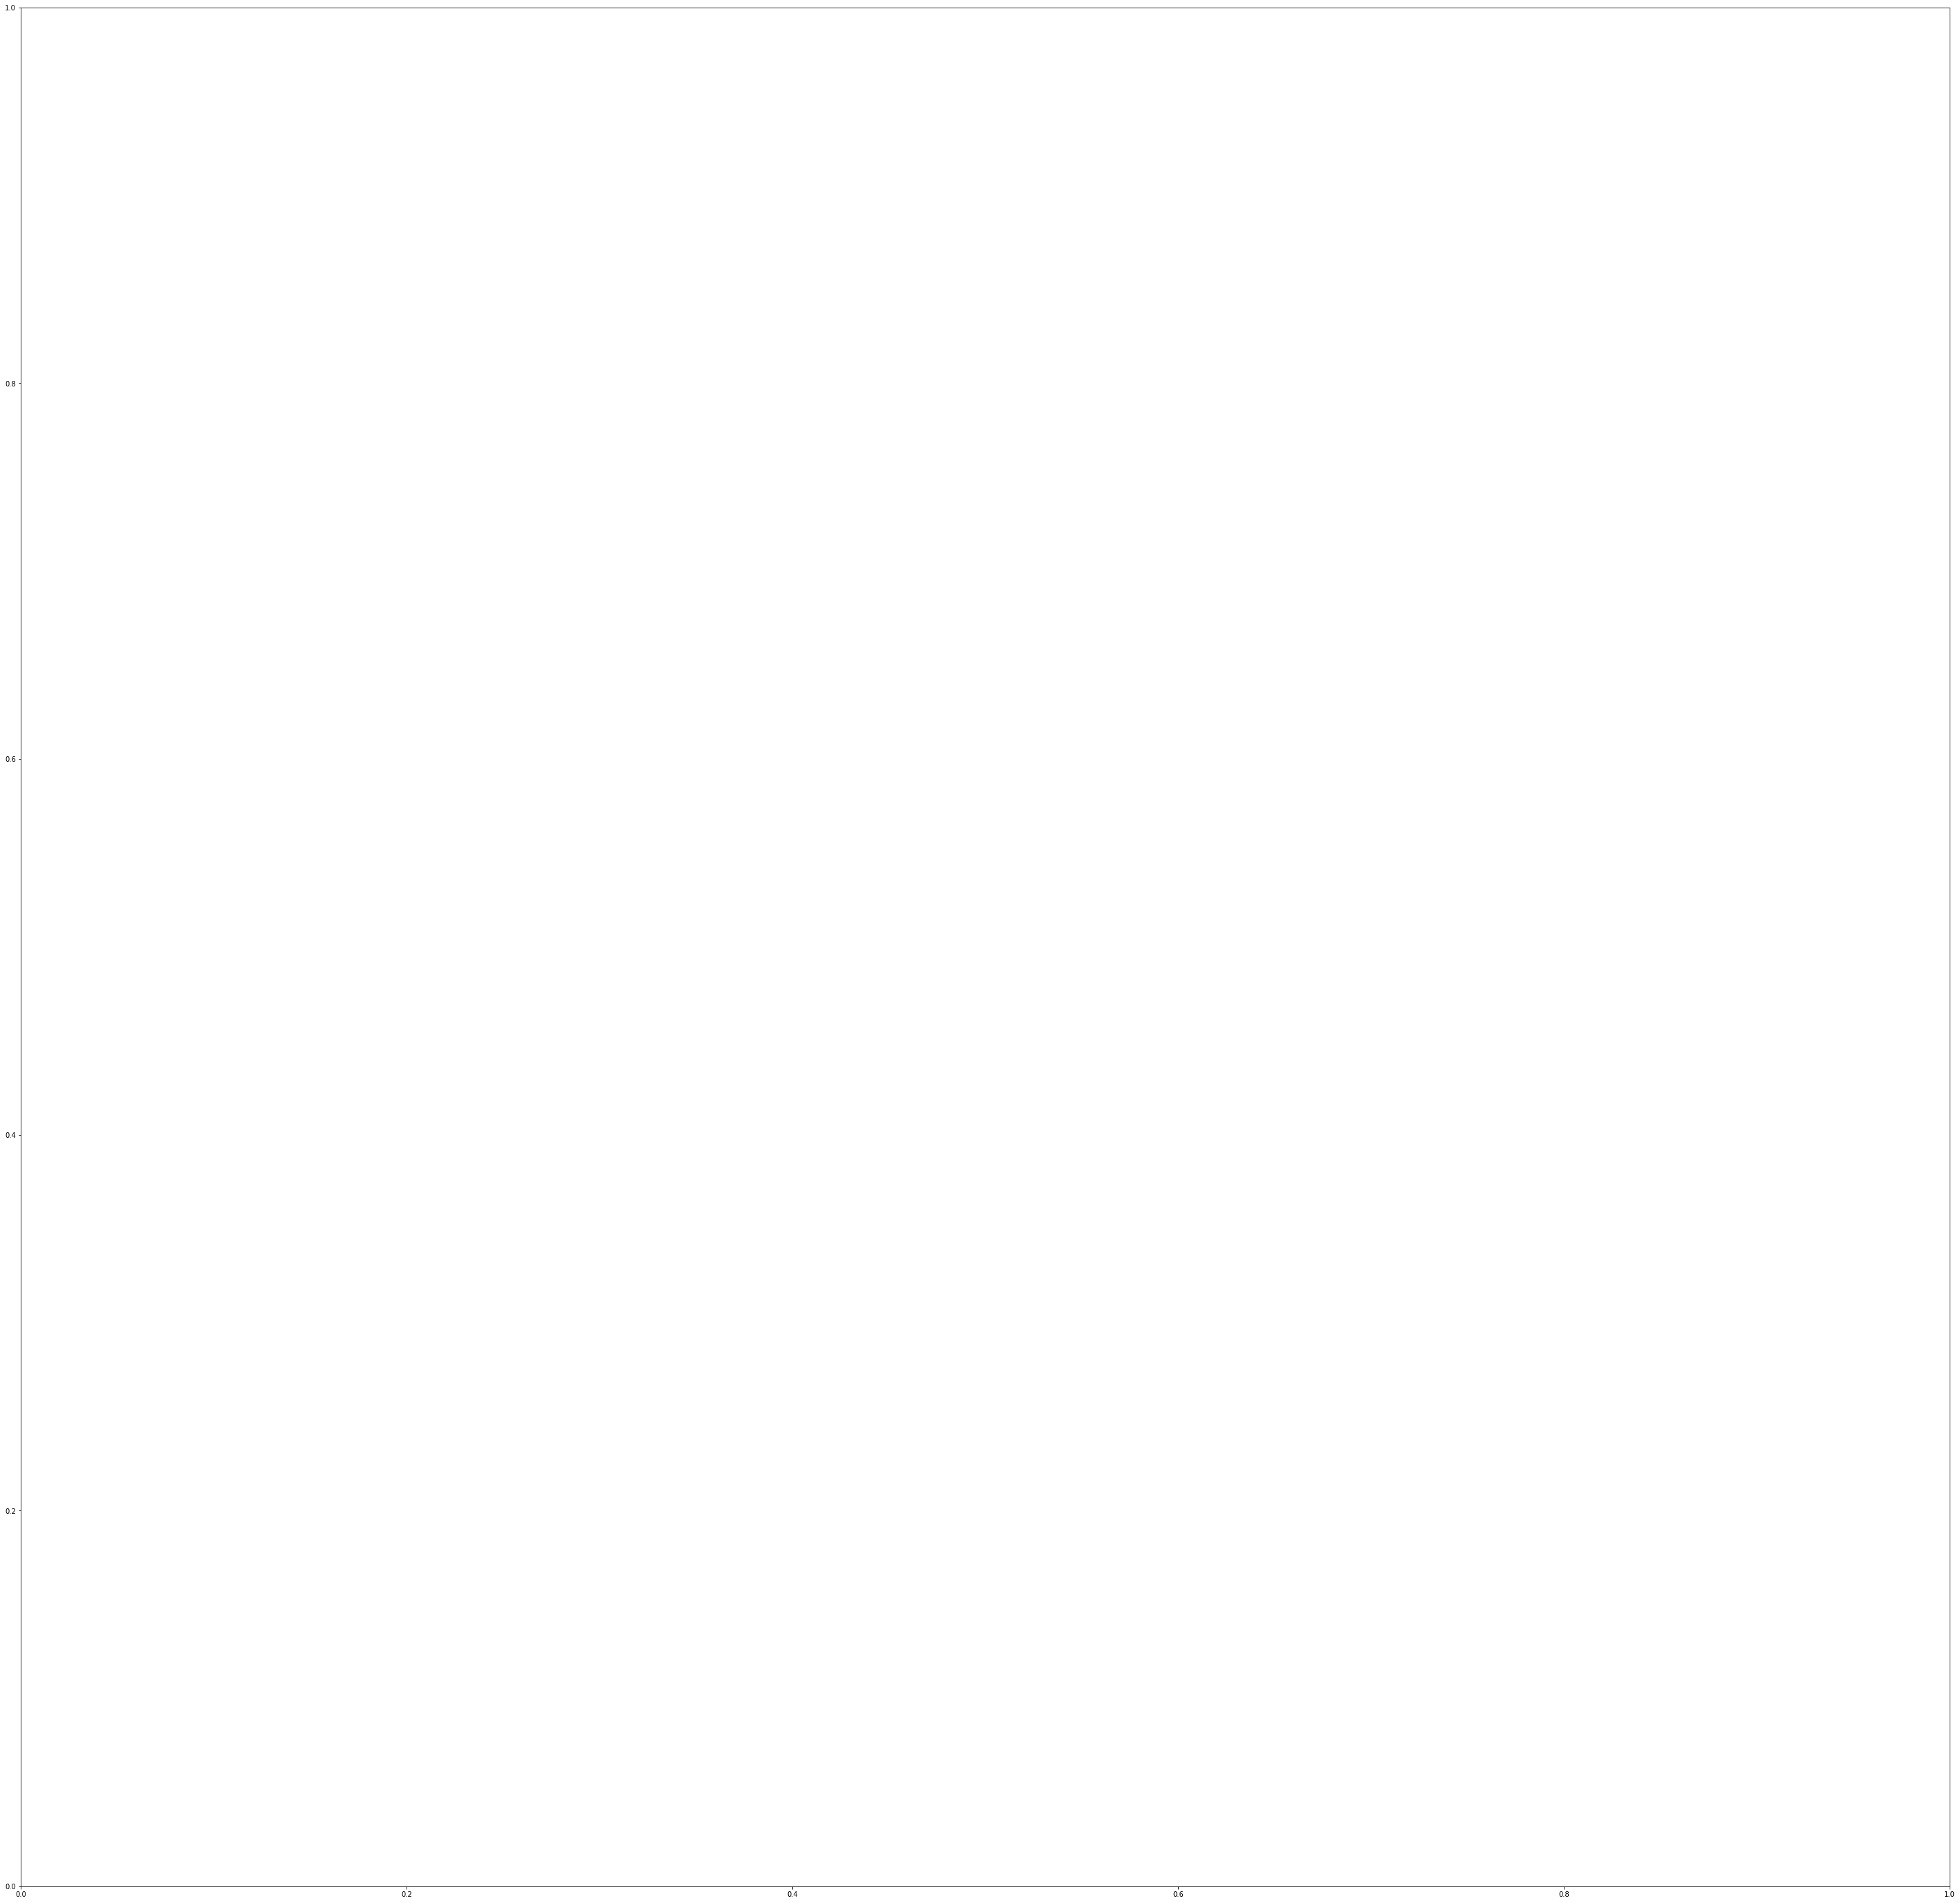

In [20]:
pwt = gdfP
pwt['centroid'] = pwt['geometry'].centroid

ax = gdfP.plot(edgecolor='grey', facecolor='w')
fig, ax = wq_P.plot(gdfP, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))

gdfP.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in pwt.iterrows():
    ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)

ax.axis('off')

In [10]:
contig_matrix = libpysal.weights.Rook.from_shapefile(pathW)

# build list of edges - this will create edges going both ways from connected nodes, so you might need to remove duplicates
nodes = contig_matrix.weights.keys()  # to get dict of keys, alternatively use contig_matrix.id2i.keys()
edges = [(node, neighbour) for node in nodes for neighbour in contig_matrix[node]]
my_graph = nx.Graph(edges)

In [42]:
contig_matrixp = libpysal.weights.Rook.from_shapefile(pathP)

# build list of edges - this will create edges going both ways from connected nodes, so you might need to remove duplicates
nodesp = contig_matrixp.weights.keys()  # to get dict of keys, alternatively use contig_matrix.id2i.keys()
edgesp = [(node, neighbour) for node in nodesp for neighbour in contig_matrixp[node]]
my_graphp = nx.Graph(edgesp)

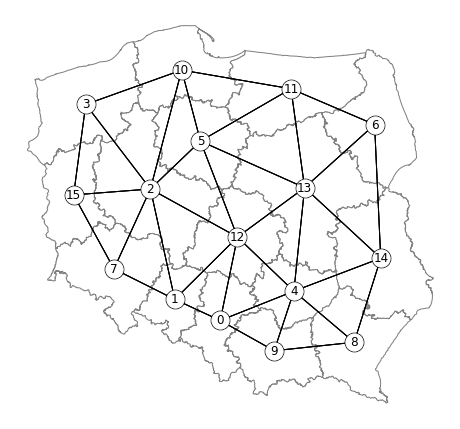

In [28]:
#plot_spatial_weights(weights, gdf, figsize=(8,8))
#ax = gdf.plot(edgecolor='grey', facecolor='w', figsize=(8,8))
#nx.draw(my_graph, pos_w)  
#fig, ax = plt.subplots(figsize=(8, 8))

#gdf.plot(edgecolor='grey', facecolor='w', ax=ax)
#gdf.boundary.plot(ax=ax, color="k")

fig, ax = plt.subplots(figsize=(8, 8))

labels={}
for i in range(len(my_graph)):
    labels[i]=i+1

#nx.draw_networkx_edges(my_graph, pos_w)

gdf.plot(edgecolor='grey', facecolor='w', ax=ax)

nx.draw_networkx_edges(my_graph, pos_w, edge_color="k")

nx.draw(my_graph, pos_w, node_color='black', node_size=350, with_labels=False)
nx.draw(my_graph, pos_w, node_color='white', with_labels=True)

#nx.draw_networkx_labels(my_graph,pos_w,labels,font_size=16)

ax.axis('off')
#plt.show()
plt.savefig('maps/images/poland_wojew_neigh.pdf', bbox_inches='tight')

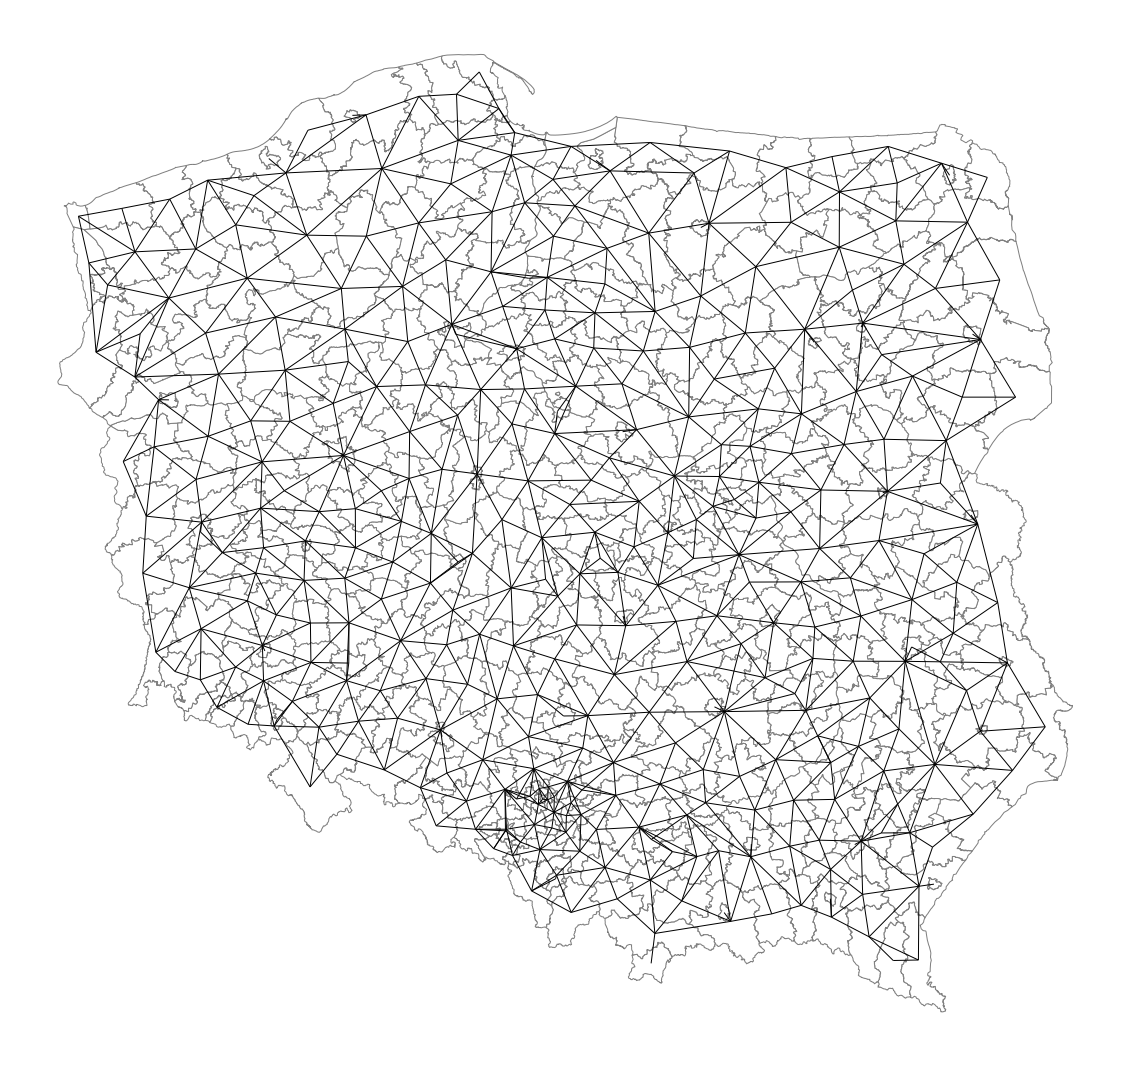

In [41]:
#plot_spatial_weights(weights, gdf, figsize=(8,8))
#ax = gdf.plot(edgecolor='grey', facecolor='w', figsize=(8,8))
#nx.draw(my_graph, pos_w)  
#fig, ax = plt.subplots(figsize=(8, 8))

#gdf.plot(edgecolor='grey', facecolor='w', ax=ax)
#gdf.boundary.plot(ax=ax, color="k")

fig, ax = plt.subplots(figsize=(20, 20))

labels={}
for i in range(len(my_graphp)):
    labels[i]=i+1

#nx.draw_networkx_edges(my_graph, pos_w)

gdfP.plot(edgecolor='grey', facecolor='w', ax=ax)

nx.draw_networkx_edges(my_graphp, pos_p, edge_color="k")

#nx.draw(my_graphp, pos_p, node_color='black', node_size=350, with_labels=False)
#nx.draw(my_graphp, pos_p, node_color='white', with_labels=True)

#nx.draw_networkx_labels(my_graph,pos_w,labels,font_size=16)

ax.axis('off')
#plt.show()
plt.savefig('maps/images/poland_pow_neigh.pdf', bbox_inches='tight')

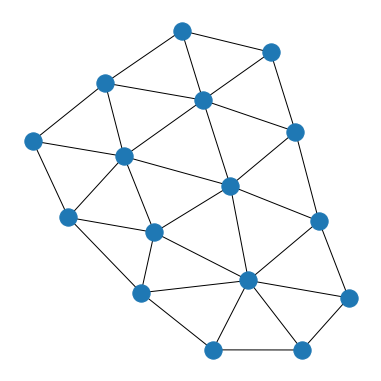

In [217]:
plt.figure(figsize=(5,5))
nx.draw(my_graph)  # networkx draw()
#plt.draw()  # pyplot draw()
plt.show()

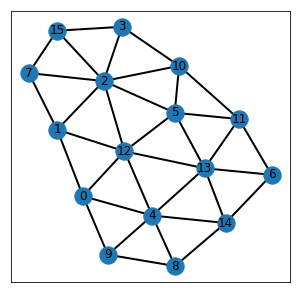

In [219]:
plt.figure(figsize=(5,5))
nx.draw_networkx(my_graph, width=2)
#plt.figure(figsize=(100,100))
plt.draw()  # pyplot draw()
plt.show()

In [220]:
contig_matrix.neighbors

{0: [1, 4, 12, 9],
 1: [0, 2, 12, 7],
 2: [1, 3, 5, 7, 10, 12, 15],
 3: [2, 10, 15],
 4: [0, 8, 9, 12, 13, 14],
 5: [2, 10, 11, 12, 13],
 6: [11, 13, 14],
 7: [1, 2, 15],
 8: [9, 4, 14],
 9: [0, 8, 4],
 10: [11, 2, 3, 5],
 11: [10, 13, 5, 6],
 12: [0, 1, 2, 4, 5, 13],
 13: [4, 5, 6, 11, 12, 14],
 14: [8, 4, 13, 6],
 15: [2, 3, 7]}

In [222]:
wojew = {}
for node in contig_matrix.neighbors:
    tmp_list = []
    for neigh in contig_matrix.neighbors[node]:
        tmp_list.append( gdfW.loc[neigh,'JPT_NAZWA_'] )
    wojew[gdfW.loc[node,'JPT_NAZWA_']] = tmp_list
wojew

{'śląskie': ['opolskie', 'świętokrzyskie', 'łódzkie', 'małopolskie'],
 'opolskie': ['śląskie', 'wielkopolskie', 'łódzkie', 'dolnośląskie'],
 'wielkopolskie': ['opolskie',
  'zachodniopomorskie',
  'kujawsko-pomorskie',
  'dolnośląskie',
  'pomorskie',
  'łódzkie',
  'lubuskie'],
 'zachodniopomorskie': ['wielkopolskie', 'pomorskie', 'lubuskie'],
 'świętokrzyskie': ['śląskie',
  'podkarpackie',
  'małopolskie',
  'łódzkie',
  'mazowieckie',
  'lubelskie'],
 'kujawsko-pomorskie': ['wielkopolskie',
  'pomorskie',
  'warmińsko-mazurskie',
  'łódzkie',
  'mazowieckie'],
 'podlaskie': ['warmińsko-mazurskie', 'mazowieckie', 'lubelskie'],
 'dolnośląskie': ['opolskie', 'wielkopolskie', 'lubuskie'],
 'podkarpackie': ['małopolskie', 'świętokrzyskie', 'lubelskie'],
 'małopolskie': ['śląskie', 'podkarpackie', 'świętokrzyskie'],
 'pomorskie': ['warmińsko-mazurskie',
  'wielkopolskie',
  'zachodniopomorskie',
  'kujawsko-pomorskie'],
 'warmińsko-mazurskie': ['pomorskie',
  'mazowieckie',
  'kujawsko-p

In [44]:
powiaty = {}
for node in contig_matrixp.neighbors:
    tmp_list = []
    for neigh in contig_matrixp.neighbors[node]:
        tmp_list.append( gdfP.loc[neigh,'JPT_NAZWA_'] )
    powiaty[gdfP.loc[node,'JPT_NAZWA_']] = tmp_list
powiaty

{'powiat ropczycko-sędziszowski': ['powiat dębicki',
  'powiat strzyżowski',
  'powiat mielecki',
  'powiat kolbuszowski',
  'powiat rzeszowski'],
 'powiat łosicki': ['powiat siemiatycki',
  'powiat bialski',
  'powiat siedlecki'],
 'powiat piaseczyński': ['powiat otwocki',
  'powiat pruszkowski',
  'powiat grodziski',
  'powiat grójecki',
  'powiat Warszawa'],
 'powiat radomski': ['powiat szydłowiecki',
  'powiat białobrzeski',
  'powiat przysuski',
  'powiat starachowicki',
  'powiat kozienicki',
  'powiat Radom',
  'powiat zwoleński',
  'powiat lipski'],
 'powiat sierpecki': ['powiat rypiński',
  'powiat płoński',
  'powiat żuromiński',
  'powiat płocki',
  'powiat lipnowski'],
 'powiat szydłowiecki': ['powiat skarżyski',
  'powiat radomski',
  'powiat przysuski',
  'powiat starachowicki',
  'powiat konecki'],
 'powiat węgrowski': ['powiat siedlecki',
  'powiat wołomiński',
  'powiat miński',
  'powiat wyszkowski',
  'powiat sokołowski',
  'powiat ostrowski'],
 'powiat gostyniński':

In [223]:
a_file = open("wojew_neighbours.pkl", "wb")

pickle.dump(wojew, a_file)

a_file.close()

In [45]:
a_file = open("powiaty_neighbours.pkl", "wb")

pickle.dump(powiaty, a_file)

a_file.close()

In [1]:
#get the length of borders

In [ ]:
# get the geometry of the places of interest
namerica = continents3857.geometry[3]   # north-america
samerica = continents3857.geometry[5]   # south-america

# get intersection between N and S America continents
na_intersect_sa = namerica.intersection(samerica)   # got multi-line

# show the length of the result (multi-line object)
blength = na_intersect_sa.length   # unit is meters on Spherical Mercator
print("Length in meters:", "%d" % blength)